In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sn
from tabulate import tabulate
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import minimize
import matplotlib.patches as mpatches
import plotly.graph_objects as go
from scipy import stats

### creating a dataframe with the daily closing prices of all the ETFs

In [2]:
df=pd.read_csv("C:\\Users\\kabra\\OneDrive - SP JAIN SCHOOL OF GLOBAL MANAGEMENT\\Desktop\\umass\\MasterFile9July.csv")
df=df.rename(columns = {'Unnamed: 0':'stock_name'})
df=df.drop('Unnamed: 1',axis=1)
df.Date=pd.to_datetime(df.Date)
dfclose = df[['Date', 'stock_name', 'Close']]
closing = dfclose.set_index('Date')
closing = closing.pivot(columns='stock_name')
closing.columns = [col[1] for col in closing.columns]
closing

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
1998-12-22,12.811,14.369,9.497,15.749,24.93,16.270,13.906,18.409,19.647
1998-12-23,12.946,14.669,9.643,16.024,25.54,16.654,13.855,18.823,19.719
1998-12-24,13.244,14.591,9.707,16.224,25.44,16.644,14.110,18.938,20.090
1998-12-28,13.128,14.514,9.586,16.330,25.51,16.539,14.037,18.662,19.912
1998-12-29,13.369,14.659,9.681,16.552,25.57,16.903,14.277,19.076,20.350
...,...,...,...,...,...,...,...,...,...
2020-07-02,57.520,37.340,22.975,68.990,105.27,58.990,57.920,101.590,129.540
2020-07-06,58.360,37.450,23.420,69.980,107.10,59.270,57.180,102.630,132.580
2020-07-07,58.360,36.260,22.940,68.640,106.03,59.830,56.960,101.730,130.430


### calculating closing log returns on the daily closing prices

In [3]:
c2cl=closing.pct_change().apply(lambda x: np.log(1+x))
c2cl=c2cl.dropna()

### Capping Log Returns to +/- 3 Standard Deviations

In [4]:
etflist=['XLB', 'XLE', 'XLF','XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
for etf in etflist:
    st=c2cl[etf].std()
    m=c2cl[etf].mean()
    c2cl[etf][c2cl[etf]<(m-(3*st))]=m-3*st
    c2cl[etf][c2cl[etf]>(m+(3*st))]=m+3*st
c2cl
#c2cl.to_csv("C:\\Users\\kabra\\OneDrive - SP JAIN SCHOOL OF GLOBAL MANAGEMENT\\Desktop\\CLOSE TO CLOSE RETURNS.csv")

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
1998-12-23,0.010483,0.020663,0.015256,0.017311,0.024174,0.023328,-0.003674,0.022240,0.003658
1998-12-24,0.022758,-0.005332,0.006615,0.012404,-0.003923,-0.000601,0.018238,0.006091,0.018640
1998-12-28,-0.008797,-0.005291,-0.012544,0.006512,0.002748,-0.006329,-0.005187,-0.014681,-0.008900
1998-12-29,0.018191,0.009941,0.009862,0.013503,0.002349,0.021770,0.016953,0.021942,0.021758
1998-12-30,-0.002921,-0.015260,-0.003933,-0.004481,-0.002741,-0.006231,-0.008158,-0.008476,-0.008389
...,...,...,...,...,...,...,...,...,...
2020-07-02,0.018600,0.011583,0.001525,0.008589,0.005429,0.004928,0.002939,0.007410,0.004022
2020-07-06,0.014498,0.002942,0.019184,0.014248,0.017234,0.004735,-0.012859,0.010185,0.023197
2020-07-07,0.000000,-0.032292,-0.020708,-0.019334,-0.010041,0.009404,-0.003855,-0.008808,-0.016350


# 5 : Main Markov States Dataset - 2 Regimes
## NO Import - Only Calculated
## Self-States Dataset Name = ss

Tests for XLB :
Adfuller Test Results:
Test Statistic:  -16.463355668225184
p Value:  2.319038904702794e-29
Number of Lags Used:  20
Count of Observations used for the ADF & Critical Values Calculation:  5390
Critical Values:  {'1%': -3.431563806497193, '5%': -2.862076379760106, '10%': -2.5670555141280667}


C:\Users\kabra\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                    XLB   No. Observations:                 5411
Model:               MarkovRegression   Log Likelihood               15852.235
Date:                Tue, 25 Aug 2020   AIC                         -31692.471
Time:                        20:07:08   BIC                         -31652.894
Sample:                             0   HQIC                        -31678.655
                               - 5411                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      5.114      0.000       0.001       0.001
sigma2      8.681e-05   3.27e-06     26.526      0.0

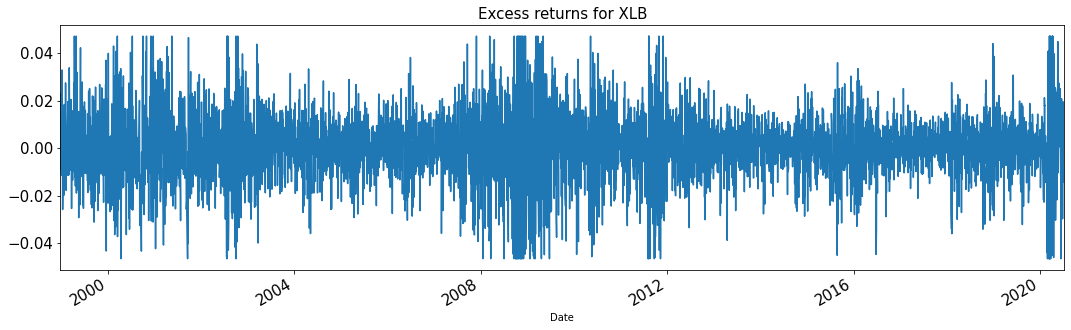

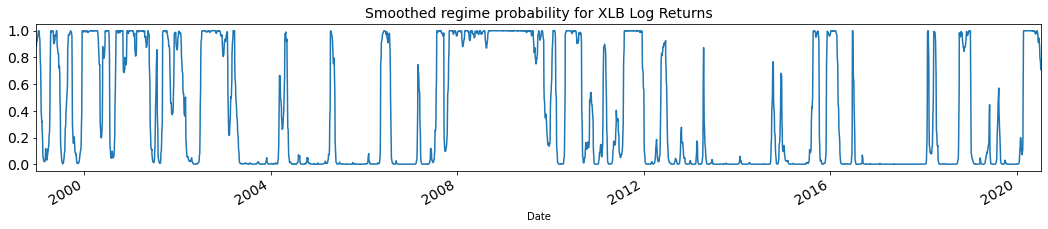

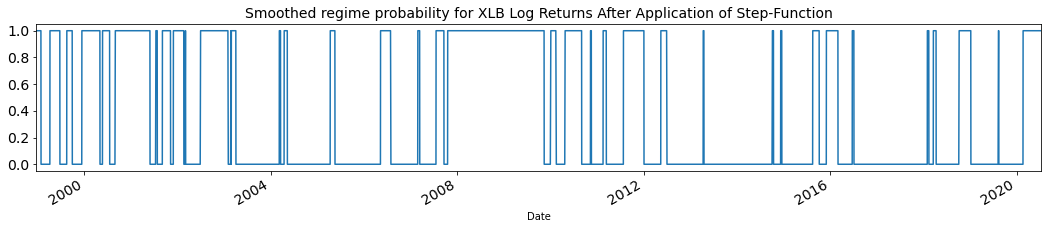


Tests for XLE :
Adfuller Test Results:
Test Statistic:  -13.849411630318004
p Value:  7.050323634071516e-26
Number of Lags Used:  33
Count of Observations used for the ADF & Critical Values Calculation:  5377
Critical Values:  {'1%': -3.4315667425260425, '5%': -2.8620776769226, '10%': -2.567056204651342}


C:\Users\kabra\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                    XLE   No. Observations:                 5411
Model:               MarkovRegression   Log Likelihood               15153.283
Date:                Tue, 25 Aug 2020   AIC                         -30294.567
Time:                        20:07:18   BIC                         -30254.990
Sample:                             0   HQIC                        -30280.751
                               - 5411                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      4.466      0.000       0.000       0.001
sigma2         0.0001   4.85e-06     26.736      0.0

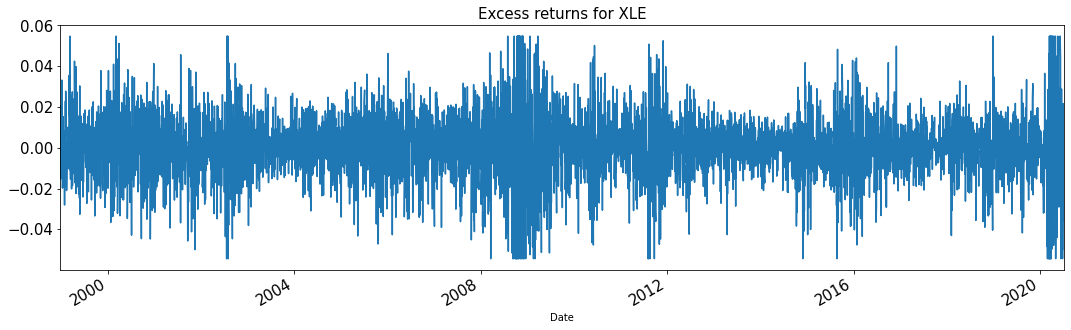

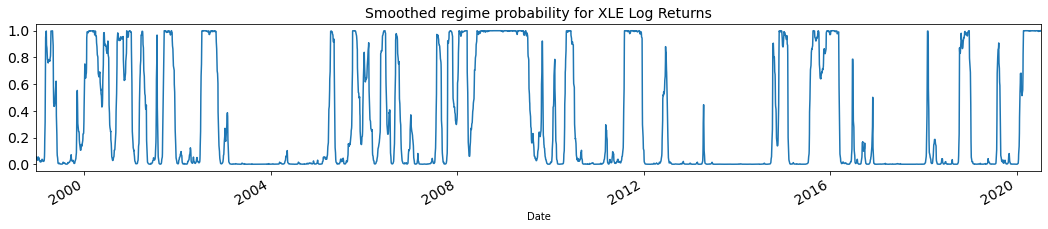

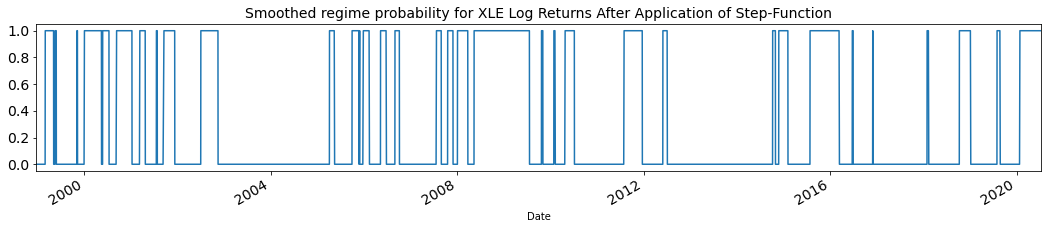


Tests for XLF :
Adfuller Test Results:
Test Statistic:  -13.486155115172375
p Value:  3.1711180971640427e-25
Number of Lags Used:  33
Count of Observations used for the ADF & Critical Values Calculation:  5377
Critical Values:  {'1%': -3.4315667425260425, '5%': -2.8620776769226, '10%': -2.567056204651342}


C:\Users\kabra\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                    XLF   No. Observations:                 5411
Model:               MarkovRegression   Log Likelihood               15742.495
Date:                Tue, 25 Aug 2020   AIC                         -31472.991
Time:                        20:07:27   BIC                         -31433.414
Sample:                             0   HQIC                        -31459.175
                               - 5411                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      4.798      0.000       0.000       0.001
sigma2      7.811e-05   2.51e-06     31.076      0.0

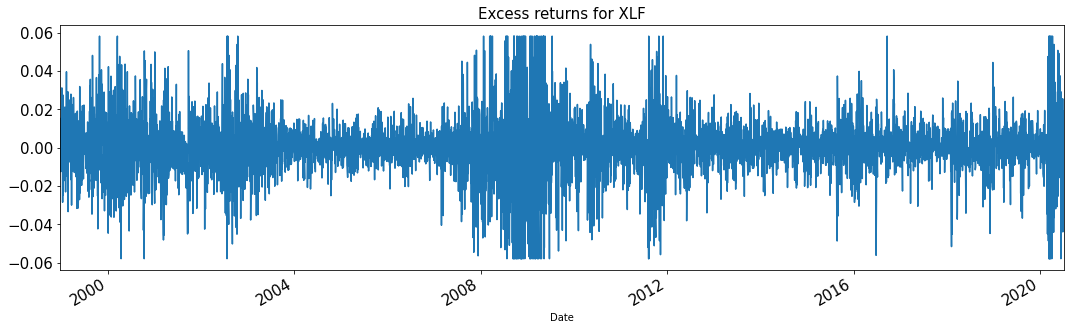

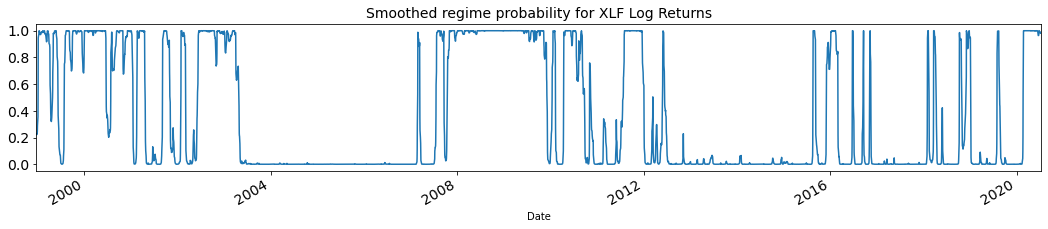

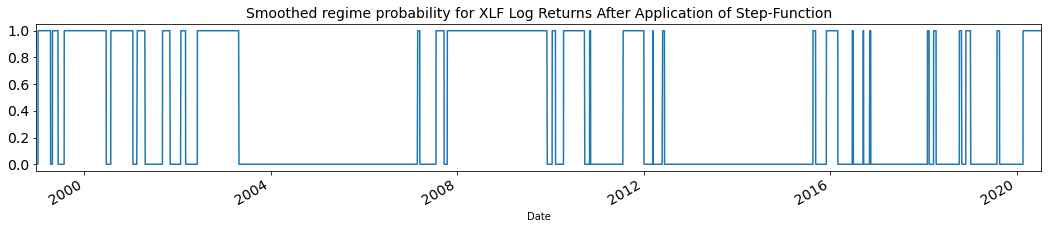


Tests for XLI :
Adfuller Test Results:
Test Statistic:  -17.546772923594506
p Value:  4.1621754129284794e-30
Number of Lags Used:  17
Count of Observations used for the ADF & Critical Values Calculation:  5393
Critical Values:  {'1%': -3.431563130963179, '5%': -2.8620760813032575, '10%': -2.5670553552494666}


C:\Users\kabra\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                    XLI   No. Observations:                 5411
Model:               MarkovRegression   Log Likelihood               16516.334
Date:                Tue, 25 Aug 2020   AIC                         -33020.668
Time:                        20:07:36   BIC                         -32981.091
Sample:                             0   HQIC                        -33006.852
                               - 5411                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      5.996      0.000       0.001       0.001
sigma2      6.667e-05   2.45e-06     27.255      0.0

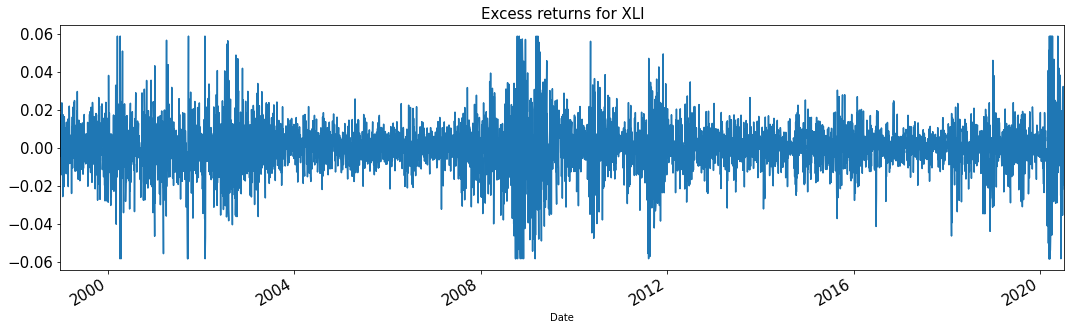

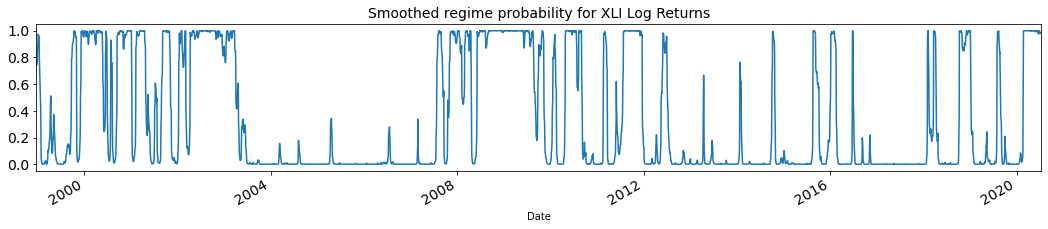

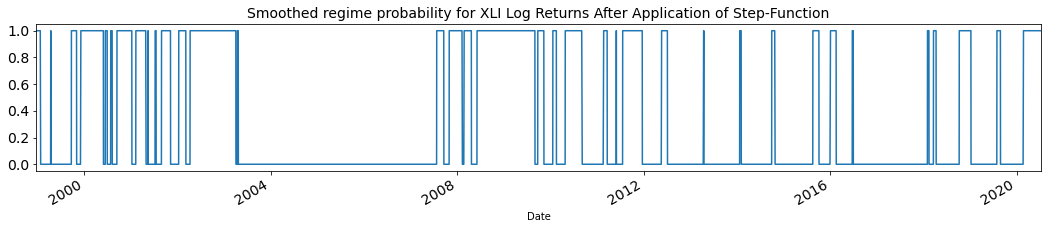


Tests for XLK :
Adfuller Test Results:
Test Statistic:  -16.12265230188366
p Value:  4.8791036803431614e-29
Number of Lags Used:  17
Count of Observations used for the ADF & Critical Values Calculation:  5393
Critical Values:  {'1%': -3.431563130963179, '5%': -2.8620760813032575, '10%': -2.5670553552494666}


C:\Users\kabra\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                    XLK   No. Observations:                 5411
Model:               MarkovRegression   Log Likelihood               15996.165
Date:                Tue, 25 Aug 2020   AIC                         -31980.329
Time:                        20:07:45   BIC                         -31940.752
Sample:                             0   HQIC                        -31966.513
                               - 5411                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      6.185      0.000       0.001       0.001
sigma2       7.48e-05   2.29e-06     32.682      0.0

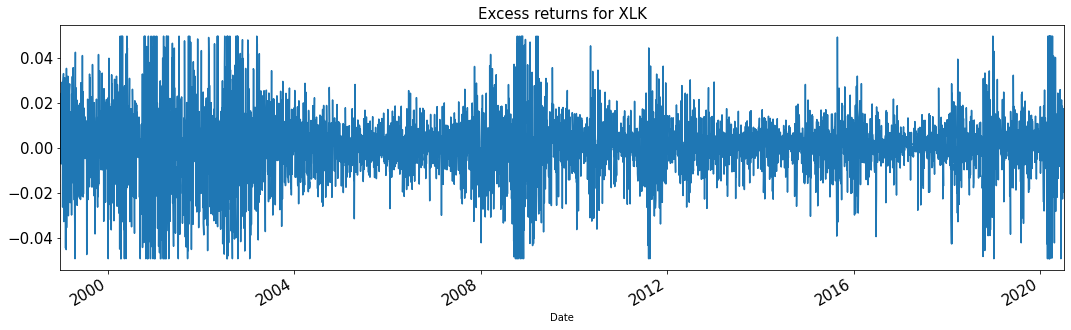

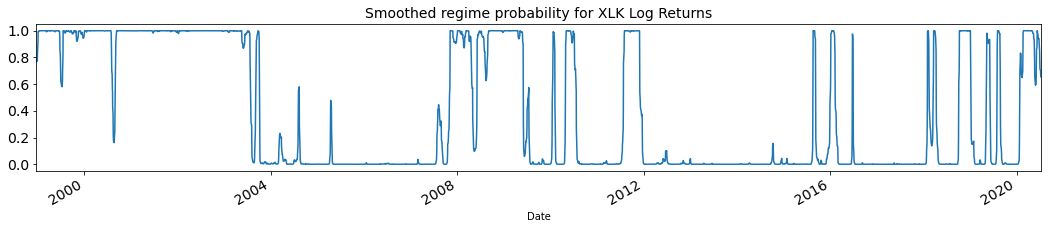

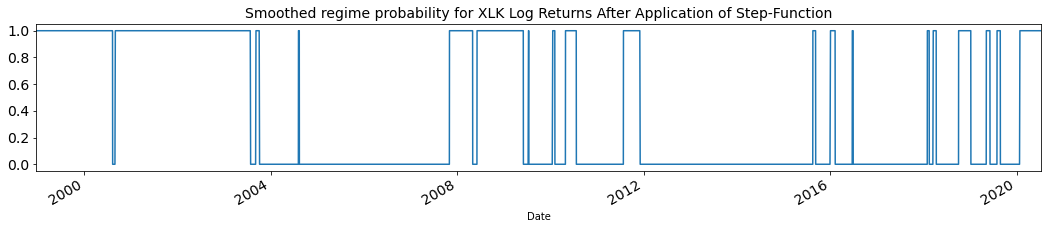


Tests for XLP :
Adfuller Test Results:
Test Statistic:  -45.216140093609816
p Value:  0.0
Number of Lags Used:  2
Count of Observations used for the ADF & Critical Values Calculation:  5408
Critical Values:  {'1%': -3.4315597645406997, '5%': -2.8620745939872885, '10%': -2.5670545635014204}


C:\Users\kabra\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                    XLP   No. Observations:                 5411
Model:               MarkovRegression   Log Likelihood               18441.894
Date:                Tue, 25 Aug 2020   AIC                         -36871.787
Time:                        20:07:55   BIC                         -36832.210
Sample:                             0   HQIC                        -36857.972
                               - 5411                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      6.043      0.000       0.000       0.001
sigma2      3.314e-05   1.24e-06     26.745      0.0

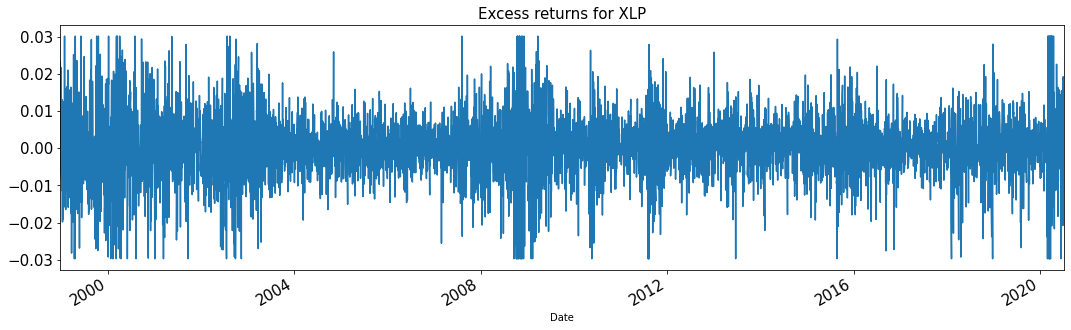

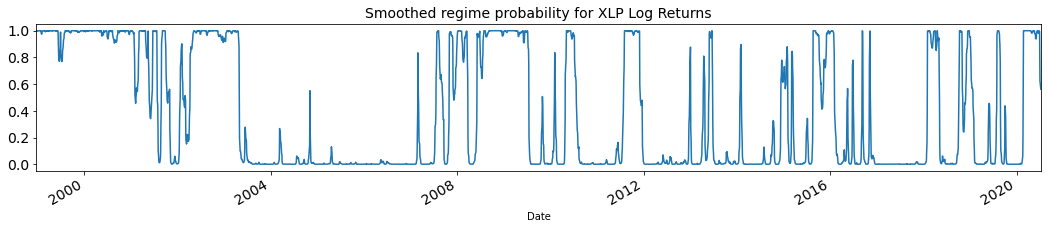

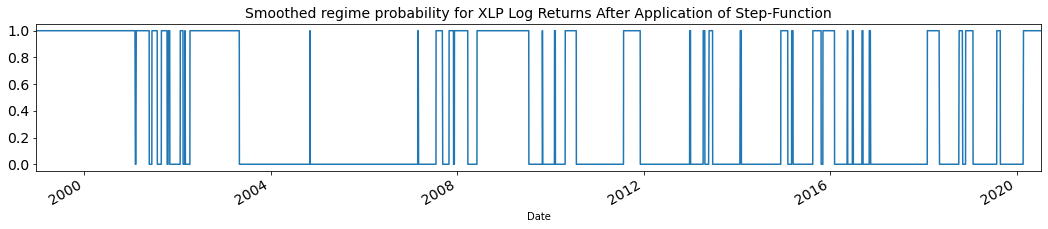


Tests for XLU :
Adfuller Test Results:
Test Statistic:  -77.75508594482773
p Value:  0.0
Number of Lags Used:  0
Count of Observations used for the ADF & Critical Values Calculation:  5410
Critical Values:  {'1%': -3.431559317095494, '5%': -2.862074396301814, '10%': -2.5670544582668504}


C:\Users\kabra\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                    XLU   No. Observations:                 5411
Model:               MarkovRegression   Log Likelihood               17265.449
Date:                Tue, 25 Aug 2020   AIC                         -34518.898
Time:                        20:08:05   BIC                         -34479.321
Sample:                             0   HQIC                        -34505.082
                               - 5411                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      5.999      0.000       0.001       0.001
sigma2      5.681e-05   2.01e-06     28.274      0.0

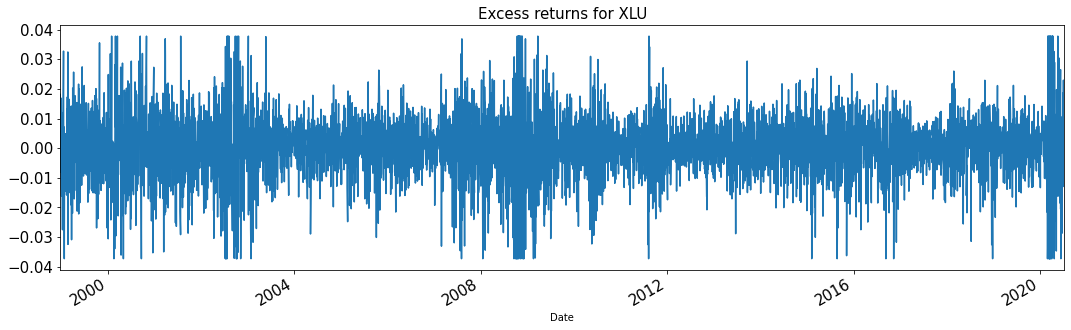

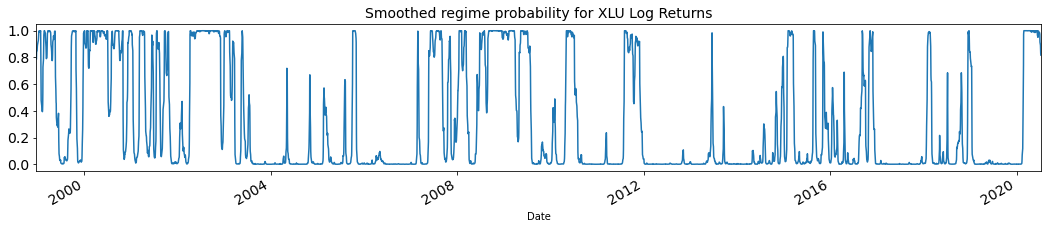

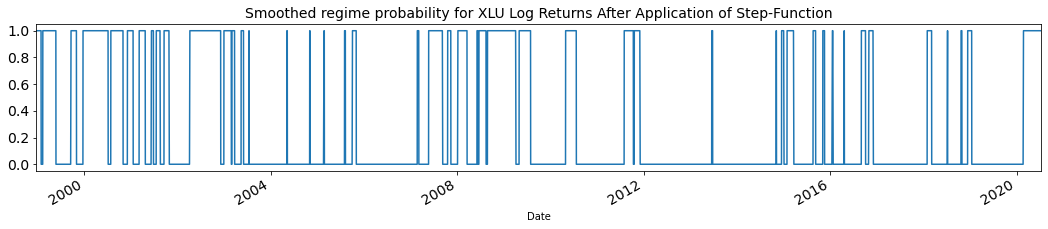


Tests for XLV :
Adfuller Test Results:
Test Statistic:  -18.959516819524893
p Value:  0.0
Number of Lags Used:  15
Count of Observations used for the ADF & Critical Values Calculation:  5395
Critical Values:  {'1%': -3.4315626810247513, '5%': -2.862075882516479, '10%': -2.5670552494285976}


C:\Users\kabra\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                    XLV   No. Observations:                 5411
Model:               MarkovRegression   Log Likelihood               17403.131
Date:                Tue, 25 Aug 2020   AIC                         -34794.262
Time:                        20:08:14   BIC                         -34754.685
Sample:                             0   HQIC                        -34780.446
                               - 5411                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      5.829      0.000       0.001       0.001
sigma2      4.726e-05    1.9e-06     24.829      0.0

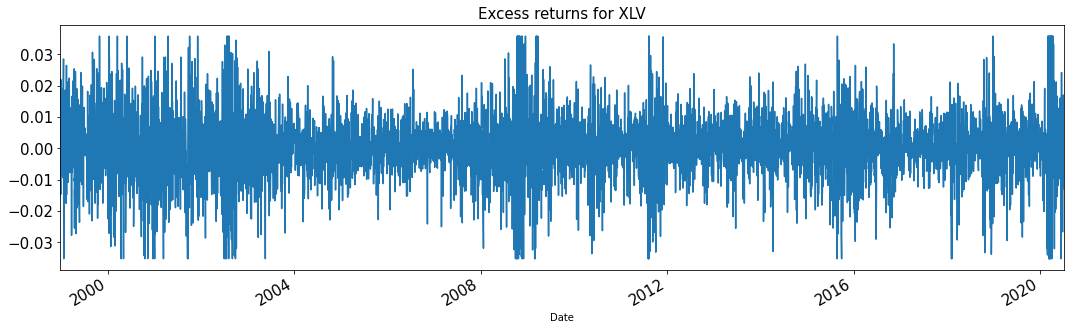

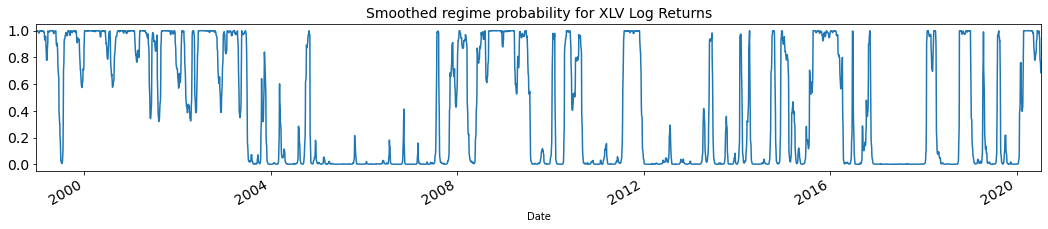

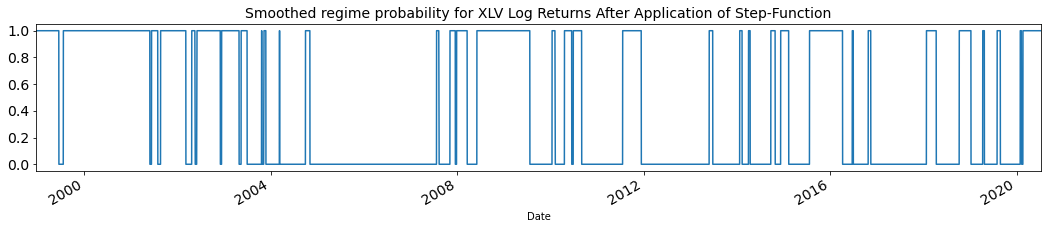


Tests for XLY :
Adfuller Test Results:
Test Statistic:  -18.166694189963042
p Value:  2.4531603384129878e-30
Number of Lags Used:  15
Count of Observations used for the ADF & Critical Values Calculation:  5395
Critical Values:  {'1%': -3.4315626810247513, '5%': -2.862075882516479, '10%': -2.5670552494285976}


C:\Users\kabra\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                    XLY   No. Observations:                 5411
Model:               MarkovRegression   Log Likelihood               16470.519
Date:                Tue, 25 Aug 2020   AIC                         -32929.037
Time:                        20:08:24   BIC                         -32889.460
Sample:                             0   HQIC                        -32915.221
                               - 5411                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      5.690      0.000       0.001       0.001
sigma2      6.039e-05   2.09e-06     28.883      0.0

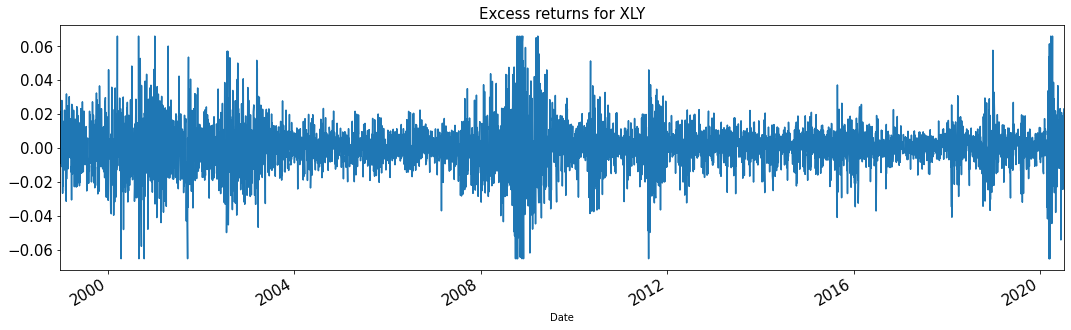

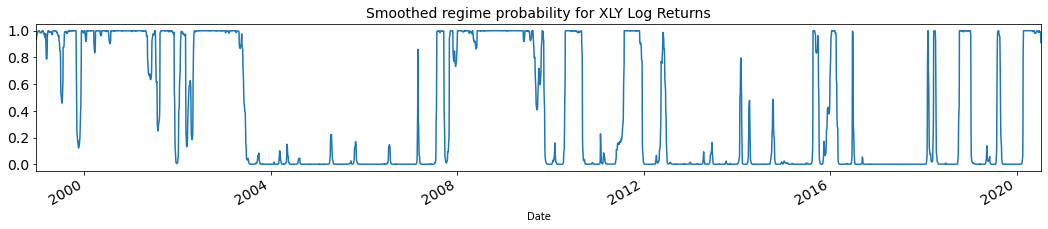

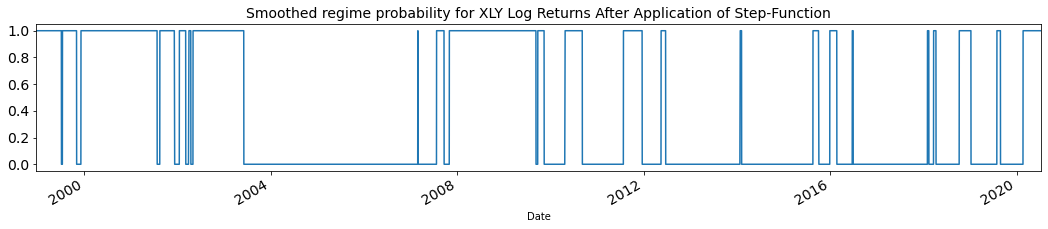

In [6]:
# plotting excess returns, adfuller test results and switching plots for etfs and vix 
def MarkovReg(etf):
    plt.title('Excess returns for '+etf,fontdict={'fontsize':15})
    (c2cl[etf].dropna()).plot(fontsize=15 , figsize=(18, 5))
    adf=adfuller(c2cl[etf].dropna())
    print('Adfuller Test Results:')
    c=0
    for i in ['Test Statistic: ','p Value: ','Number of Lags Used: ','Count of Observations used for the ADF & Critical Values Calculation: ','Critical Values: ']:
        print(i,adf[c])
        c+=1
    if etf=='VIXCLS':
        mod_kns = sm.tsa.MarkovRegression(c2cl[etf].dropna(), k_regimes=2, trend='c')
        res_kns = mod_kns.fit()
        print(res_kns.summary())
        plt.show()
    else:
        mod_kns = sm.tsa.MarkovRegression(c2cl[etf].dropna(), k_regimes=2, trend='c', switching_variance=True)
        res_kns = mod_kns.fit()
        print(res_kns.summary())
        plt.show()
    switching(res_kns, etf)
    res_kns.smoothed_marginal_probabilities[1]=changeToStep(res_kns.smoothed_marginal_probabilities[1])
    newDf(res_kns.smoothed_marginal_probabilities[1],etf)
    switching(res_kns, etf," After Application of Step-Function")
    
def changeToStep(array):
    arr=[]
    for i in array:
        if i>0.5:
            arr.append(1)
        else:
            arr.append(0)
    return arr

def newDf(df,etf):
    ex=pd.DataFrame(df)
    ex.columns=['State']
    st=(pd.DataFrame(c2cl[etf])).join(ex,how='inner')
    lyst.append(st)
    
def switching(res_kns, etf,s=""):
    if etf=='VIXCLS':
        plt.title('Smoothed regime probability for '+etf+' Actual Levels'+s,fontdict={'fontsize':14})
        (res_kns.smoothed_marginal_probabilities[1]).plot(fontsize=14, figsize=(18, 3))
        plt.show()
    else:
        plt.title('Smoothed regime probability for '+etf+' Log Returns'+s,fontdict={'fontsize':14})
        (res_kns.smoothed_marginal_probabilities[1]).plot(fontsize=14, figsize=(18, 3))
        plt.show()
    
lyst=[]
for name in ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']:
    print('Tests for', name, ":")
    MarkovReg(name)
    print()

### Calculating risk and return

In [ ]:
sectors=['Materials','Energy','Financial','Industrial','Technology','Staples','Utility','Health','Consumer']
etflist=['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
temp=[]
for i in range(9):
    temp.append(list([sectors[i],etflist[i],(lyst[i][lyst[i].State==0]).mean()[0]*25000,(lyst[i][lyst[i].State==0]).std()[0]*np.sqrt(250)*100,(lyst[i][lyst[i].State==0]).count()[0],(lyst[i][lyst[i].State==1]).mean()[0]*25000,(lyst[i][lyst[i].State==1]).std()[0]*np.sqrt(250)*100,(lyst[i][lyst[i].State==1]).count()[0]]))
cols=["Sector","ETF","AvgReturn:State 0","Vol:State 0","Count:State 0","AvgReturn:State 1","Vol:State 1","Count:State 1"]
print("-------------")
print("ANNUAL VALUES")
print("-------------")
print("------------------------")
print("State 0: Low Volatility")
print("State 1: High Volatility")
print("------------------------")
print(tabulate(temp,headers=cols))

### T-stat for self-states of ETFs

In [ ]:
temp2=[]
for i in range(9):
    temp2.append(list([sectors[i],etflist[i],(stats.ttest_ind(lyst[i][lyst[i].State==0],lyst[i][lyst[i].State==1], equal_var=False)[0][0]),(stats.ttest_ind(lyst[i][lyst[i].State==0],lyst[i][lyst[i].State==1], equal_var=False)[1][0])]))
cols=["Sector","ETF","Statistic","p value"]
print("--------------------------------------------------------------")
print("TStat on Returns in High and Low Vol - Using individual states")
print("--------------------------------------------------------------")
print(tabulate(temp2,headers=cols))

### Regime switching on the VIX dataset

In [ ]:
mod_kns = sm.tsa.MarkovRegression(vix.VIXCLS.dropna(),k_regimes=2, trend='c',switching_variance=True)
res_kns = mod_kns.fit()
print(res_kns.summary())
vpystates=res_kns.smoothed_marginal_probabilities[1]
plt.figure(figsize=(17,3))
plt.plot(vix.VIXCLS.dropna().index,res_kns.smoothed_marginal_probabilities[1],marker='o',color='k')
plt.xticks(fontweight="bold",fontsize=15)
plt.yticks(fontweight="bold",fontsize=15)
plt.xlabel("Date",fontsize=15,fontweight="bold")
plt.ylabel("Smooth Probabilities",fontsize=15,fontweight="bold")
vss=pd.DataFrame(res_kns.smoothed_marginal_probabilities[1])
vss=vss.rename(columns={1:'probs'})
plt.show()
res_kns.smoothed_marginal_probabilities[1]=changeToStep(vpystates)
plt.figure(figsize=(17,3))
plt.plot(vix.VIXCLS.dropna().index,res_kns.smoothed_marginal_probabilities[1],color='k')
plt.xticks(fontweight="bold",fontsize=15)
plt.yticks(fontweight="bold",fontsize=15)
plt.xlabel("Date",fontsize=15,fontweight="bold")
plt.ylabel("Volatility States",fontsize=15,fontweight="bold")
vs=pd.DataFrame(res_kns.smoothed_marginal_probabilities[1])
plt.show()
vs=vs.rename(columns={1:'probadj'})
vs=vs.join(vss,how="inner")
vs

### calculating risk and return 

In [ ]:
l=[]
ex=pd.DataFrame(vs['probadj'])
ex.columns=['VIXState']
for etf in etflist:
    st=(pd.DataFrame(c2c[etf])).join(ex,how='inner')
l.append(st)


temp=[]
for i in range(9):
    temp.append(list([sectors[i],etflist[i],(l[i][l[i].VIXState==0]).mean()[0]*25000,(l[i][l[i].VIXState==0]).std()[0]*np.sqrt(250)*100,(l[i][l[i].VIXState==1]).mean()[0]*25000,(l[i][l[i].VIXState==1]).std()[0]*np.sqrt(250)*100]))
cols=["Sector","ETF","AvgReturn:State 0","Vol:State 0","AvgReturn:State 1","Vol:State 1"]
print("-----------------------------------")
print("ANNUAL VALUES using VIX as a Signal")
print("-----------------------------------")
print("--------------------------------------")
print("State 0: Low Volatility   Count: ",str((l[0][l[0].VIXState==0]).count()[0]))
print("State 1: High Volatility  Count: ",str((l[0][l[0].VIXState==1]).count()[0]))
print("--------------------------------------")
print(tabulate(temp,headers=cols))


### T-stat for VIX 

In [ ]:
temp2=[]
for i in range(9):
    temp2.append(list([sectors[i],etflist[i],(stats.ttest_ind(l[i][l[i].VIXState==0],l[i][l[i].VIXState==1], equal_var=False)[0][0]),(stats.ttest_ind(l[i][l[i].VIXState==0],l[i][l[i].VIXState==1], equal_var=False)[1][0])]))
cols=["Sector","ETF","Statistic","p value"]
print("--------------------------------------------------")
print("TStat - Using VIX states - close to close returns")
print("--------------------------------------------------")
print(tabulate(temp2,headers=cols))